In [7]:
nocturnal_species = [
    'asiope1',  # Oriental Scops Owl
    'brwowl1',  # Brown Wood Owl
    'insowl1',  # Indian Scops Owl
    'junowl1',  # Jungle Owlet
    'spoowl1',  # Spotted Owlet
    'sbeowl1',  # Short-eared Owl
    'sttwoo1'   # Spot-bellied Eagle Owl
]


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ✅ Load full training labels
labels_path = "E:/birdclef-2024/train_labels.csv"
df = pd.read_csv(labels_path)

# ✅ Nocturnal species list
nocturnal_species = [
    'asiope1', 'brwowl1', 'insowl1', 'junowl1',
    'spoowl1', 'sbeowl1', 'sttwoo1'
]

# ✅ Filter dataset
df = df[df['species'].isin(nocturnal_species)].reset_index(drop=True)
print(f"Total nocturnal samples: {len(df)} | Species: {df['species'].nunique()}")

# ✅ Rename for consistency with your Dataset class
df = df.rename(columns={"species": "label", "filename": "filepath"})
df["filepath"] = df.apply(lambda row: f"E:/birdclef-2024/spectrograms/{row['label']}/{row['filepath']}", axis=1)

# ✅ Train/val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# ✅ Save splits
train_df.to_csv("nocturnal_train_split.csv", index=False)
val_df.to_csv("nocturnal_val_split.csv", index=False)

print("✅ Nocturnal dataset splits saved.")


Total nocturnal samples: 3389 | Species: 7
✅ Nocturnal dataset splits saved.


In [43]:
from torch.utils.data import Dataset
from PIL import Image

class BirdCLEFDataset(Dataset):
    def __init__(self, df, transform=None, label2idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label2idx = label2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image = Image.open(row['filepath']).convert("RGB")
        label = self.label2idx[row['label']]
        if self.transform:
            image = self.transform(image)
        return image, label


In [45]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("nocturnal_train_split.csv")
val_df = pd.read_csv("nocturnal_val_split.csv")

label2idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

from torch.utils.data import DataLoader

train_dataset = BirdCLEFDataset(train_df, transform=image_transforms, label2idx=label2idx)
val_dataset = BirdCLEFDataset(val_df, transform=image_transforms, label2idx=label2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [49]:
import timm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=7)
model.to(device)


EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [53]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [55]:
from tqdm import tqdm

best_val_acc = 0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_acc = evaluate(model, val_loader)

    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_nocturnal_model.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")


Epoch 1/10: 100%|██████████| 85/85 [06:40<00:00,  4.71s/it, loss=0.638]


Epoch 1 | Loss: 1.2238 | Train Acc: 60.60% | Val Acc: 82.30%
✅ Saved best model at epoch 1 with Val Acc: 82.30%


Epoch 2/10: 100%|██████████| 85/85 [06:43<00:00,  4.75s/it, loss=0.108] 


Epoch 2 | Loss: 0.1415 | Train Acc: 96.57% | Val Acc: 86.43%
✅ Saved best model at epoch 2 with Val Acc: 86.43%


Epoch 3/10: 100%|██████████| 85/85 [06:32<00:00,  4.62s/it, loss=0.0239] 


Epoch 3 | Loss: 0.0385 | Train Acc: 99.56% | Val Acc: 88.50%
✅ Saved best model at epoch 3 with Val Acc: 88.50%


Epoch 4/10: 100%|██████████| 85/85 [06:35<00:00,  4.65s/it, loss=0.0187] 


Epoch 4 | Loss: 0.0187 | Train Acc: 99.93% | Val Acc: 89.53%
✅ Saved best model at epoch 4 with Val Acc: 89.53%


Epoch 5/10: 100%|██████████| 85/85 [06:38<00:00,  4.69s/it, loss=0.0128] 


Epoch 5 | Loss: 0.0116 | Train Acc: 100.00% | Val Acc: 90.41%
✅ Saved best model at epoch 5 with Val Acc: 90.41%


Epoch 6/10: 100%|██████████| 85/85 [06:36<00:00,  4.66s/it, loss=0.00297]


Epoch 6 | Loss: 0.0077 | Train Acc: 99.96% | Val Acc: 90.56%
✅ Saved best model at epoch 6 with Val Acc: 90.56%


Epoch 7/10: 100%|██████████| 85/85 [06:36<00:00,  4.67s/it, loss=0.0162]  


Epoch 7 | Loss: 0.0060 | Train Acc: 100.00% | Val Acc: 91.00%
✅ Saved best model at epoch 7 with Val Acc: 91.00%


Epoch 8/10: 100%|██████████| 85/85 [06:37<00:00,  4.67s/it, loss=0.0312]  


Epoch 8 | Loss: 0.0055 | Train Acc: 99.96% | Val Acc: 91.30%
✅ Saved best model at epoch 8 with Val Acc: 91.30%


Epoch 9/10: 100%|██████████| 85/85 [06:33<00:00,  4.63s/it, loss=0.00123] 


Epoch 9 | Loss: 0.0039 | Train Acc: 100.00% | Val Acc: 91.74%
✅ Saved best model at epoch 9 with Val Acc: 91.74%


Epoch 10/10: 100%|██████████| 85/85 [06:35<00:00,  4.65s/it, loss=0.000536]


Epoch 10 | Loss: 0.0023 | Train Acc: 100.00% | Val Acc: 91.74%


In [57]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label2idx.keys()))


              precision    recall  f1-score   support

     asiope1       1.00      0.50      0.67         4
     brwowl1       0.93      0.98      0.95       281
     insowl1       0.95      0.93      0.94        85
     junowl1       0.90      0.93      0.91       126
     sbeowl1       0.91      0.81      0.86        78
     spoowl1       0.91      0.83      0.87        59
     sttwoo1       0.84      0.84      0.84        45

    accuracy                           0.92       678
   macro avg       0.92      0.83      0.86       678
weighted avg       0.92      0.92      0.92       678



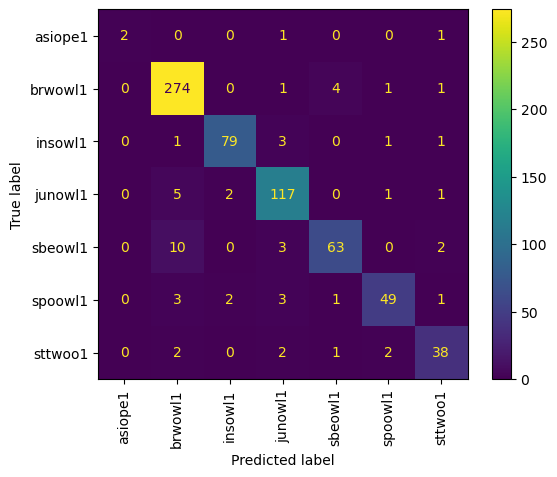

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2idx.keys()))
disp.plot(xticks_rotation='vertical', cmap='viridis')


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ✅ Load full training labels
labels_path = 'balanced_dataset.csv'
df = pd.read_csv(labels_path)

# ✅ Nocturnal species list
nocturnal_species = [
    'asiope1', 'brwowl1', 'insowl1', 'junowl1',
    'spoowl1', 'sbeowl1', 'sttwoo1'
]

# ✅ Filter dataset
df = df[df['label'].isin(nocturnal_species)].reset_index(drop=True)
print(f"Total nocturnal samples: {len(df)} | Species: {df['label'].nunique()}")



Total nocturnal samples: 920 | Species: 7
